# PuGo Modeling

## Step 4: Generate Final Outputs

This script takes the optimized buckets from Step 3 and allows for massaging of values according to different criteria. 

### Goals

This notebook uses outputs from Step 2 to generate the final outputs for PuGo scholarship awards.


### Process

* A. Import data and perform sanity checks.
* B. Compare current admit rates to historic
* C. Check state of unread applications.
* D. Generate buckets/bins
* E. Massage scholarship bin values
* F. Check final outputs

## Part A - Load data and modules
### Part A1 - Load modules

In [25]:
#import needed packages
import pandas as pd;
import pickle;
import numpy as np;
import os;
import matplotlib.pyplot as plt;

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

%matplotlib inline

### Part A2 - Load data

In [27]:
#data to use
data = pd.read_csv('NewFallApplicantList.csv') #new applicant data
historical = pd.read_csv('PuGoHistorical.csv') #historical data

In [28]:
#import best individuals from optimizations
creator.create('FitnessMulti', base.Fitness, weights=(0.99, 0.01))
creator.create('Individual', list, fitness=creator.FitnessMulti)

model_location = '../optimization/bestInds/final/'
files = os.listdir(model_location)

store = {}
for each in files:
    with open(model_location + each, 'rb') as model_input:
        current = pickle.load(model_input)
        store[each.split('.')[0]] = list(current)

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [26]:
#number of buckets to use. This should be the same as in the optimization code
number_of_buckets = 20

## Part B - Compare current admit rates to historic

In [29]:
data.head()

AcademicQtrKeyId  ApplQtr  ApplYr  FiscalYr  SDBSrcSystemKey  \
0             20183        3    2018      2019          1967522   
1             20183        3    2018      2019          1967800   
2             20183        3    2018      2019          1970035   
3             20183        3    2018      2019          1971107   
4             20183        3    2018      2019          1974353   

                                     StudentName  AdmitStatus  \
0  WRIGHT,WILLIAM                                      Unread   
1  HUANG,GARETT                                        Unread   
2  MONTOYA,JUAN                                        Unread   
3  BOND,EVELYN                                    NotAdmitted   
4  MENDES,BIANCA                                       Unread   

   HolisticAcademicScore  HolisticPQAScore  HolisticAdmissionScore  \
0                     10                 6                      10   
1                     11                 8                      11   
2                      6                 6                       6   
3                      0                 0                       0   
4                      6                 6                       6   

       ...        Other_Budget  Tuition              FINGroupings  \
0      ...               16431    36578        FIN2 - $0 Unfunded   
1      ...               16431    36578  FIN5 - $30K-40K Unfunded   
2      ...               16431    36578    FIN 6 - $40K+ Unfunded   
3      ...               16431    36578           FIN1 - No FAFSA   
4      ...               16431    36578           FIN1 - No FAFSA   

   HS_For_Lang_Yrs  HS_Math_Level  HS_Yrs_Arts  HS_Yrs_For_Lang  HS_Yrs_Math  \
0                3              4            0                0            0   
1                5              4            0                0            0   
2                2              3            0                0            0   
3                0              0            0                0            0   
4                2              3            0                0            0   

   HS_Yrs_Science HS_Yrs_Soc_Sci  
0               0              0  
1               0              0  
2               0              0  
3               0              0  
4               0              0  

[5 rows x 49 columns]

In [30]:
#status for current applicants
data.AdmitStatus.value_counts()

Unread         12639
Admitted        9677
NotAdmitted      403
Name: AdmitStatus, dtype: int64

In [31]:
historical.head()

AcademicQtrKeyId  ApplYr  ApplQtr  FiscalYr  SDBSrcSystemKey  \
0             20174    2017        4      2018          1911633   
1             20174    2017        4      2018          1900064   
2             20174    2017        4      2018          1896511   
3             20174    2017        4      2018          1890052   
4             20174    2017        4      2018          1893371   

              StudentName  Enrolled  Admitted  PuGoOffer  \
0          VONTELA,ANJALI         0         0          0   
1      JOHN,ANDERSON ALEX         0         0          0   
2   CAVLAN,LETICIA ALEXIS         0         0          0   
3  BEAUDRY,BENJAMIN OSCAR         0         0          0   
4   CRAWFORD,CARLOS JAMES         0         0          0   

   HolisticAcademicScore       ...        Other_Budget  Tuition  \
0                     12       ...               15621    35538   
1                     12       ...               15621    35538   
2                      8       ...               15621    35538   
3                     10       ...               15621    35538   
4                     10       ...               15621    35538   

               FINGroupings  HS_For_Lang_Yrs  HS_Math_Level  HS_Yrs_Arts  \
0  FIN5 - $30K-40K Unfunded              2.0            5.0          0.0   
1           FIN1 - No FAFSA              3.0            5.0          2.0   
2  FIN4 - $15K-30K Unfunded              3.0            4.0          2.0   
3        FIN2 - $0 Unfunded              3.0            4.0          3.0   
4        FIN2 - $0 Unfunded              3.0            4.0          0.0   

   HS_Yrs_For_Lang  HS_Yrs_Math  HS_Yrs_Science  HS_Yrs_Soc_Sci  
0              0.0          0.0             0.0             0.0  
1              3.0          4.0             4.0             3.0  
2              3.0          4.0             4.0             2.0  
3              3.0          4.0             4.0             0.0  
4              3.0          5.0             3.0             3.0  

[5 rows x 74 columns]

In [32]:
#admits from previous years
historicalAdmits = historical[historical.Admitted == 1]
historicalAdmits['offered'] = historicalAdmits.PuGoOffer > 0 #admits with offers
#pct of admits with a PuGo offer by year
historicalAdmits[historicalAdmits.offered].groupby('ApplYr')['ApplQtr'].count() / historicalAdmits.groupby('ApplYr')['ApplQtr'].count()

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ApplYr
2014    0.431812
2015    0.659998
2016    0.481343
2017    0.832416
Name: ApplQtr, dtype: float64

In [33]:
#acceptance rates
rates = historical[historical.Admitted == 1].groupby('ApplYr')['ApplQtr'].count() / historical.groupby('ApplYr')['ApplQtr'].count()
lastYear = historical.ApplYr.max()
rateLastYear = rates[lastYear]
rateLastYear #rate for pervious year of applications

0.44517006802721087

In [34]:
data['Admitted'] = data.AdmitStatus == 'Admitted'

In [35]:
data.Admitted.value_counts() / len(data) #this is the current admit rate

False    0.574057
True     0.425943
Name: Admitted, dtype: float64

In [36]:
admits = data[data.Admitted] #number of students admitted
len(admits)

9677

In [37]:
additionalStudents = int(round(len(data) * rateLastYear) - len(admits))
additionalStudents #this is the number of additional students that need to be admitted to be at the previous year's rate

437

## Part C - Check state of unread applications

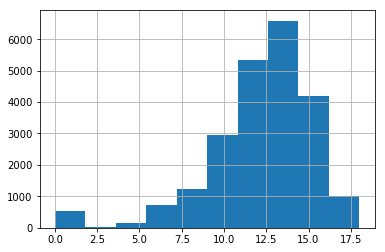

In [38]:
#compare holistic score distributions of unread applicants. 
#These results should change how much PuGo money is held out for unread applications
data.HolisticAcademicScore.hist()

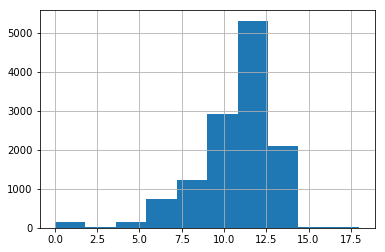

In [39]:
data[data.AdmitStatus == 'Unread'].HolisticAcademicScore.hist()

In [40]:
data[(data.AdmitStatus == 'Unread') & data.HolisticAcademicScore > 14]

Empty DataFrame
Columns: [AcademicQtrKeyId, ApplQtr, ApplYr, FiscalYr, SDBSrcSystemKey, StudentName, AdmitStatus, HolisticAcademicScore, HolisticPQAScore, HolisticAdmissionScore, Parent1_Ed_Level, Parent2_Ed_Level, HighestParentalEducation, TestScore, AcademicScore, AcademicRank, HS_AI, HS_GPA, HighSchoolCode, HS_State, AgeDecimal, AgeYrs, FirstGeneration_4YrDegree, FirstGeneration_Matriculated, Athlete, CollegeInTheHighSchool, RunningStart, TR_GPA, EntryClass, AlumOffspring, Conditional, Provisional, Major_Req1, Dependency, FAFSAFiledOnTime, EFC, Income, GrantSchol, Total_Budget, Other_Budget, Tuition, FINGroupings, HS_For_Lang_Yrs, HS_Math_Level, HS_Yrs_Arts, HS_Yrs_For_Lang, HS_Yrs_Math, HS_Yrs_Science, HS_Yrs_Soc_Sci, Admitted]
Index: []

[0 rows x 50 columns]

## Part D - Generate buckets/bins

In [41]:
#create the buckets for admits. Same process as in Step 3
admits = admits.sort_values(['HolisticAcademicScore', 'HS_GPA', 'TestScore'], na_position = 'last')
admits['BucketRank'] = np.arange(len(admits))
admits['Bucket'] = pd.cut(admits['BucketRank'], number_of_buckets, labels = False)

In [42]:
#this will be used to look at how the buckets are being divided
mins = admits.groupby('Bucket')['HolisticAcademicScore', 'HS_GPA', 'TestScore'].min()
maxes = admits.groupby('Bucket')['HolisticAcademicScore', 'HS_GPA', 'TestScore'].max()
minsMaxes = mins.join(maxes, rsuffix = '_max', lsuffix = '_min')
minsMaxes = minsMaxes.reset_index()

In [43]:
minsMaxes #this is the basis for one of the final outputs

Bucket  HolisticAcademicScore_min  HS_GPA_min  TestScore_min  \
0        0                         10        3.10          840.0   
1        1                         14        3.31         1140.0   
2        2                         14        3.62         1030.0   
3        3                         14        3.70         1030.0   
4        4                         14        3.75          950.0   
5        5                         14        3.80         1040.0   
6        6                         14        3.84          970.0   
7        7                         14        3.89          950.0   
8        8                         14        3.94          920.0   
9        9                         14        3.20         1080.0   
10      10                         15        3.77         1130.0   
11      11                         15        3.86         1010.0   
12      12                         15        3.48         1070.0   
13      13                         16        3.69         1220.0   
14      14                         16        3.83         1170.0   
15      15                         16        3.90         1140.0   
16      16                         16        3.94         1150.0   
17      17                         16        3.48         1220.0   
18      18                         17        3.83         1220.0   
19      19                         17        3.59         1300.0   

    HolisticAcademicScore_max  HS_GPA_max  TestScore_max  
0                          14        4.00         1590.0  
1                          14        3.62         1600.0  
2                          14        3.70         1600.0  
3                          14        3.75         1570.0  
4                          14        3.80         1600.0  
5                          14        3.84         1560.0  
6                          14        3.89         1570.0  
7                          14        3.94         1600.0  
8                          14        4.00         1560.0  
9                          15        4.00         1600.0  
10                         15        3.86         1600.0  
11                         15        3.95         1600.0  
12                         16        4.00         1600.0  
13                         16        3.83         1600.0  
14                         16        3.89         1600.0  
15                         16        3.94         1600.0  
16                         16        3.99         1600.0  
17                         17        4.00         1600.0  
18                         17        4.00         1600.0  
19                         18        4.00         1600.0

## Part E - Massage scholarship bin values

The goal here is to try to limit the variability in award amounts across scenarios without rolling back results of the optimization. This was done with an understanding/intuition of how different optimization scenarious will play out.

In [44]:
store.keys() #all scenarios to be looked at

['55_noExtra', '65_noExtra', '75_extra', '65_extra', '55_extra', '75_noExtra']

In [45]:
target = len(admits) * 1.0 / (len(admits) + additionalStudents) #approx pct to hold off on awarding. Check that adtl students > 0
print target
print target * 3500000 #if extra $500K to be used
print target * 3100000

0.956792564762
3348773.97667
2966056.95076


In [46]:
for k, v in zip(store.keys(), store.values()): #print all bucket values
    print k
    print np.array(v)
    print '\n'

55_noExtra
[   0    0    0    0    0    0    0    0    0 3000 3000 3000 3000 6000 6900
 6900 7200 7200 7200 8400]


65_noExtra
[   0    0    0    0    0    0    0 3000 3000 3000 3000 3000 3000 3000 3000
 6900 7200 7200 7200 8400]


75_extra
[   0    0    0    0    0 3000 3000 3000 3300 3300 3300 3300 4200 4200 5700
 5700 6300 7200 7200 8400]


65_extra
[   0    0    0    0    0    0    0 3000 3000 3000 3000 3900 5100 6000 7200
 7200 7200 7200 7200 7200]


55_extra
[   0    0    0    0    0    0    0    0    0 3000 4200 5700 5700 6000 6900
 7200 7200 8100 8400 8400]


75_noExtra
[   0    0    0    0    0 3000 3000 3000 3000 3000 3000 3000 3000 3000 3000
 3000 6600 7200 7200 8400]




In [47]:
# this is where values are reset for all buckets/bins
store['75_extra'] = [   0,    0,    0,    0,    1500, 1500, 3000, 3000, 3000, 3000, 3000, 4200, 4200, 4200, 6000,
 6000, 6000, 7200, 8400, 8400]

store['65_extra'] = [   0,    0,    0,    0,    0,    0,    1500, 1500, 3000, 3000, 4200, 4200, 4200, 6000, 6000,
 7200, 7200, 7200, 8400, 8400]

store['55_extra'] = [   0,   0,   0,    0,    0,    0,    0,    0,    1500, 1500, 4500, 6000, 6000, 7200, 7200,
 7200, 7200, 7200, 8400, 8400]

In [48]:
store['75_noExtra'] = [   0,    0,    0,    0,    1500, 1500, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
 5400, 5400, 7200, 7200, 8400]

store['65_noExtra'] = [   0,    0,   0,    0,    0,    0,   1500, 1500, 3000, 3000, 3000, 3000, 3000, 5400, 5400,
 5400, 7200, 7200, 7200, 8400]

store['55_noExtra'] = [   0,    0,    0,    0,    0,    0,    0,    0,    1500, 1500, 3000, 3000, 5400, 5400, 5400,
 7200, 7200, 7200, 7200, 8400]

In [49]:
output = admits[['SDBSrcSystemKey', 'HolisticAcademicScore', 'HS_GPA', 'TestScore', 'Bucket']]

keys = store.keys()
keys = sorted(keys)

newCols = []
for each in keys: #rename columns and assign values in the min/max dataframe. This will have to be changed later!!(!!)
    splits = each.split('_')
    colOut = str(int(splits[0]) + 5)
    colOut = 'offer_' + colOut
    if splits[1] == 'extra':
        colOut = colOut + '_addtlFunds'
    
    bucketDF = pd.DataFrame({colOut : store[each], 'Bucket' : range(len(store[each]))}) #update bucket DF with values
    output = output.merge(bucketDF, on = 'Bucket', how = 'left')
    minsMaxes = minsMaxes.merge(bucketDF, on = 'Bucket', how = 'left')
    newCols.append(colOut)
    print colOut + ': ' + str(len(bucketDF)) + ', ' + str(output[colOut].sum()) #sanity checks that amounts offered are OK

offer_60_addtlFunds: 20, 34981500
offer_60: 20, 30191400
offer_70_addtlFunds: 20, 34836600
offer_70: 20, 31064400
offer_80_addtlFunds: 20, 35127900
offer_80: 20, 30772500


In [50]:
len(output) #total number of students in applicant pool

9677

In [51]:
minsMaxes

Bucket  HolisticAcademicScore_min  HS_GPA_min  TestScore_min  \
0        0                         10        3.10          840.0   
1        1                         14        3.31         1140.0   
2        2                         14        3.62         1030.0   
3        3                         14        3.70         1030.0   
4        4                         14        3.75          950.0   
5        5                         14        3.80         1040.0   
6        6                         14        3.84          970.0   
7        7                         14        3.89          950.0   
8        8                         14        3.94          920.0   
9        9                         14        3.20         1080.0   
10      10                         15        3.77         1130.0   
11      11                         15        3.86         1010.0   
12      12                         15        3.48         1070.0   
13      13                         16        3.69         1220.0   
14      14                         16        3.83         1170.0   
15      15                         16        3.90         1140.0   
16      16                         16        3.94         1150.0   
17      17                         16        3.48         1220.0   
18      18                         17        3.83         1220.0   
19      19                         17        3.59         1300.0   

    HolisticAcademicScore_max  HS_GPA_max  TestScore_max  offer_60_addtlFunds  \
0                          14        4.00         1590.0                    0   
1                          14        3.62         1600.0                    0   
2                          14        3.70         1600.0                    0   
3                          14        3.75         1570.0                    0   
4                          14        3.80         1600.0                    0   
5                          14        3.84         1560.0                    0   
6                          14        3.89         1570.0                    0   
7                          14        3.94         1600.0                    0   
8                          14        4.00         1560.0                 1500   
9                          15        4.00         1600.0                 1500   
10                         15        3.86         1600.0                 4500   
11                         15        3.95         1600.0                 6000   
12                         16        4.00         1600.0                 6000   
13                         16        3.83         1600.0                 7200   
14                         16        3.89         1600.0                 7200   
15                         16        3.94         1600.0                 7200   
16                         16        3.99         1600.0                 7200   
17                         17        4.00         1600.0                 7200   
18                         17        4.00         1600.0                 8400   
19                         18        4.00         1600.0                 8400   

    offer_60  offer_70_addtlFunds  offer_70  offer_80_addtlFunds  offer_80  
0          0                    0         0                    0         0  
1          0                    0         0                    0         0  
2          0                    0         0                    0         0  
3          0                    0         0                    0         0  
4          0                    0         0                 1500      1500  
5          0                    0         0                 1500      1500  
6          0                 1500      1500                 3000      3000  
7          0                 1500      1500                 3000      3000  
8       1500                 3000      3000                 3000      3000  
9       1500                 3000      3000                 3000      3000  
10      3000              

## Part F - Check final outputs

Sanity checks to see how allocations fared

In [52]:
output.sample(n = 1).iloc[0] #randomly sample a student; see if they can be traced to appropriate bucket above

SDBSrcSystemKey          1980771.00
HolisticAcademicScore         14.00
HS_GPA                         3.95
TestScore                   1380.00
Bucket                         8.00
offer_60_addtlFunds         1500.00
offer_60                    1500.00
offer_70_addtlFunds         3000.00
offer_70                    3000.00
offer_80_addtlFunds         3000.00
offer_80                    3000.00
Name: 3932, dtype: float64

In [53]:
output.groupby('HolisticAcademicScore')[newCols].mean() #mean, median, min, max values by academic score

offer_60_addtlFunds     offer_60  offer_70_addtlFunds  \
HolisticAcademicScore                                                          
10                                0.000000     0.000000             0.000000   
11                                0.000000     0.000000             0.000000   
12                                0.000000     0.000000             0.000000   
13                                0.000000     0.000000             0.000000   
14                              231.085117   231.085117           823.544052   
15                             4689.320388  3297.258709          3960.822387   
16                             7175.752577  6445.113402          6660.371134   
17                             8311.034483  7309.655172          8311.034483   
18                             8400.000000  8400.000000          8400.000000   

                          offer_70  offer_80_addtlFunds     offer_80  
HolisticAcademicScore                                                 
10                        0.000000             0.000000     0.000000  
11                        0.000000             0.000000     0.000000  
12                        0.000000             0.000000     0.000000  
13                        0.000000             0.000000     0.000000  
14                      823.544052          1545.918367  1545.918367  
15                     3000.000000          3629.811536  3000.000000  
16                     6038.103093          5822.597938  4720.824742  
17                     7309.655172          8311.034483  7309.655172  
18                     8400.000000          8400.000000  8400.000000

In [54]:
output.groupby('HolisticAcademicScore')[newCols].median()

offer_60_addtlFunds  offer_60  offer_70_addtlFunds  \
HolisticAcademicScore                                                       
10                                       0         0                    0   
11                                       0         0                    0   
12                                       0         0                    0   
13                                       0         0                    0   
14                                       0         0                    0   
15                                    6000      3000                 4200   
16                                    7200      7200                 7200   
17                                    8400      7200                 8400   
18                                    8400      8400                 8400   

                       offer_70  offer_80_addtlFunds  offer_80  
HolisticAcademicScore                                           
10                            0                    0         0  
11                            0                    0         0  
12                            0                    0         0  
13                            0                    0         0  
14                            0                 1500      1500  
15                         3000                 4200      3000  
16                         5400                 6000      5400  
17                         7200                 8400      7200  
18                         8400                 8400      8400

In [55]:
output.groupby('HolisticAcademicScore')[newCols].min()

offer_60_addtlFunds  offer_60  offer_70_addtlFunds  \
HolisticAcademicScore                                                       
10                                       0         0                    0   
11                                       0         0                    0   
12                                       0         0                    0   
13                                       0         0                    0   
14                                       0         0                    0   
15                                    1500      1500                 3000   
16                                    6000      5400                 4200   
17                                    7200      7200                 7200   
18                                    8400      8400                 8400   

                       offer_70  offer_80_addtlFunds  offer_80  
HolisticAcademicScore                                           
10                            0                    0         0  
11                            0                    0         0  
12                            0                    0         0  
13                            0                    0         0  
14                            0                    0         0  
15                         3000                 3000      3000  
16                         3000                 4200      3000  
17                         7200                 7200      7200  
18                         8400                 8400      8400

In [56]:
output.groupby('HolisticAcademicScore')[newCols].max()

offer_60_addtlFunds  offer_60  offer_70_addtlFunds  \
HolisticAcademicScore                                                       
10                                       0         0                    0   
11                                       0         0                    0   
12                                       0         0                    0   
13                                       0         0                    0   
14                                    1500      1500                 3000   
15                                    6000      5400                 4200   
16                                    7200      7200                 7200   
17                                    8400      8400                 8400   
18                                    8400      8400                 8400   

                       offer_70  offer_80_addtlFunds  offer_80  
HolisticAcademicScore                                           
10                            0                    0         0  
11                            0                    0         0  
12                            0                    0         0  
13                            0                    0         0  
14                         3000                 3000      3000  
15                         3000                 4200      3000  
16                         7200                 7200      7200  
17                         8400                 8400      8400  
18                         8400                 8400      8400

In [57]:
output.Bucket.value_counts()

3     484
7     484
8     484
16    484
1     484
9     484
17    484
2     484
18    484
0     484
11    484
19    484
4     484
12    484
13    484
6     484
14    484
10    483
5     483
15    483
Name: Bucket, dtype: int64

In [58]:
#save outputs
output.to_csv('offers.csv', index = False)
minsMaxes.to_csv('bands.csv', index = False)